In [1]:
import numpy
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
%matplotlib inline  


/Users/chronowanderer/anaconda3/envs/tensorflow/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
TIME_STEPS = 8
HIDDEN_UNITS = 32
INPUT_UNITS = 2
OUTPUT_UNITS = 2
BATCH_SIZE = 64
TRAIN_SIZE = 100
EFFECTIVE_COEFFICIENT = 0.25
EFFECTIVE_LOC = int(TRAIN_SIZE / EFFECTIVE_COEFFICIENT)
EPOCH = 10
look_back = TIME_STEPS


In [3]:
def atan_positive(x, y):
    if (x > 0) & (y > 0):
        theta = math.atan(y / x)
    elif (x == 0) & (y > 0):
        theta = math.pi / 2
    elif (x < 0):
        theta = math.pi + math.atan(y / x)
    elif (x == 0) & (y < 0):
        theta = 3 * math.pi / 2
    elif (x > 0) & (y <= 0):
        theta = 2 * math.pi + math.atan(y / x)
    return theta

def brwnm2(mu1, mu2, a, sigma, h, lentmax):
    locRT = 0
    theta_T = 999
    x = mu1 * h + sigma * numpy.random.randn(lentmax) * math.sqrt(h)
    y = mu2 * h + sigma * numpy.random.randn(lentmax) * math.sqrt(h)
    a_r = a - math.sqrt(h) * sigma / 2.0
    x_start = 0.0
    y_start = 0.0
    w = [x_start]
    z = [y_start] 
    flag = 0
    for k in numpy.arange(1, lentmax):
        w.append(w[k - 1] + x[k])
        z.append(z[k - 1] + y[k])
        if (flag == 0) & (w[k] ** 2 + z[k] ** 2 >= a_r ** 2):
            locRT = k
            theta_T = atan_positive(w[k], z[k]) / 2.0
            flag = 1
    return (w, z, theta_T, locRT)


In [4]:
def semicircular_error(r, t):
    e = r - t
    if e >= 90:
        e = e - 180
    elif e < -90:
        e = e + 180
    return e


In [5]:
numSeries = 500 # training & testing & sequently predicting
numPredict = 100 # complete prediction
tmax = 3.0
h = 0.001
lentmax = int(tmax / h)
T = numpy.linspace(0, tmax, lentmax, endpoint = False)
DATA_i = 0
DATA_f = lentmax - 1
norm, a, sigma = [], [], []
Target, Response, Error, RTloc = [], [], [], []
Dat = []

i = 0
while i < (numSeries + numPredict):    
    if (i < numSeries):
        norm0 = 1.0
        a0 = 1.0
        sigma0 = 1.0
        RESP = 40
    else:
        norm0 = numpy.random.uniform(0.1, 10)
        a0 = numpy.random.uniform(0.1, 10)
        sigma0 = numpy.random.uniform(0.1, 10)
        RESP = numpy.random.randint(0, 180)    
    if RESP == 0:
        RESP = 180
    mu1 = norm0 * math.cos(2 * RESP * math.pi / 180)
    mu2 = norm0 * math.sin(2 * RESP * math.pi / 180)
    (L_x, L_y, theta, t_loc) = brwnm2(mu1, mu2, a0, sigma0, h, lentmax)
    if t_loc >= EFFECTIVE_LOC:
        norm.append(norm0)
        a.append(a0)
        sigma.append(sigma0)
        Target.append(RESP)
        Response.append(theta / math.pi * 180)
        Error.append(semicircular_error(theta / math.pi * 180, RESP))
        RTloc.append(t_loc)
        temp = []
        for j in numpy.arange(lentmax):
            temp.append([L_x[j], L_y[j]])
        Dat.append(temp)
        i = i + 1

Dat = numpy.array(Dat) # all data
Data = Dat[0 : numSeries, :, :] # training & testing & sequently predicting
Data_p = Dat[numSeries : numSeries + numPredict, :, :] # complete prediction

dataset, dataset_t = [], []
for i in numpy.arange(numSeries):
    for j in numpy.arange(lentmax):
        dataset.append(Data[i, j])
        dataset_t.append(Data[i, j])
dataset = numpy.array(dataset)
dataset_p = []
for i in numpy.arange(numPredict):
    for j in numpy.arange(lentmax):
        dataset_p.append(Data_p[i, j])
        dataset_t.append(Data_p[i, j])
predict = numpy.array(dataset_p)
dataset_t = numpy.array(dataset_t)

print dataset.shape, predict.shape, dataset_t.shape


(1500000, 2) (300000, 2) (1800000, 2)


In [6]:
# convert an array of values into a dataset matrix
def create_dataset(series, size, dataset, look_back):
    dataX, dataY = [], []
    for k in range(series):
        kk = k * size
        for i in range(size - look_back):
            a = dataset[(kk+i) : (kk+i+look_back), :]
            dataX.append(a)
            dataY.append(dataset[kk+i+look_back, :])
    return numpy.array(dataX), numpy.array(dataY)


In [7]:
TOTAL_TIME = Data.shape[1]

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset_t = scaler.fit_transform(dataset_t)
dataset = dataset_t[0:numSeries*lentmax, :]
predict = dataset_t[numSeries*lentmax:(numSeries+numPredict)*lentmax, :]

# split into train and test sets
train_size = TRAIN_SIZE
test_size = TOTAL_TIME - train_size + look_back
train, test = [], []
for k in range(numSeries):
    kk = k * TOTAL_TIME
    for t in range(kk, kk+train_size):
        train.append(dataset[t, :])
    for t in range(kk+train_size-look_back, kk+TOTAL_TIME):
        test.append(dataset[t, :])
train = numpy.array(train)
test = numpy.array(test)
        
print train.shape, test.shape, predict.shape

# use this function to prepare the train and test datasets for modeling
trainX, trainY = create_dataset(numSeries, train_size, train, look_back)
testX, testY = create_dataset(numSeries, test_size, test, look_back)
predictX, predictY = create_dataset(numPredict, TOTAL_TIME, predict, look_back)

# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], look_back, trainX.shape[2]))
testX = numpy.reshape(testX, (testX.shape[0], look_back, testX.shape[2]))
predictX = numpy.reshape(predictX, (predictX.shape[0], look_back, predictX.shape[2]))

print trainX.shape, trainY.shape
print testX.shape, testY.shape
print predictX.shape, predictY.shape


(50000, 2) (1454000, 2) (300000, 2)
(46000, 8, 2) (46000, 2)
(1450000, 8, 2) (1450000, 2)
(299200, 8, 2) (299200, 2)


In [8]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(HIDDEN_UNITS, input_shape=(look_back, INPUT_UNITS)))
model.add(Dense(OUTPUT_UNITS))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs = EPOCH, batch_size = BATCH_SIZE, verbose = 2)


Epoch 1/10
 - 8s - loss: 0.0045
Epoch 2/10
 - 7s - loss: 8.7009e-06
Epoch 3/10
 - 8s - loss: 8.3537e-06
Epoch 4/10
 - 9s - loss: 7.9300e-06
Epoch 5/10
 - 8s - loss: 7.5559e-06
Epoch 6/10
 - 8s - loss: 6.9850e-06
Epoch 7/10
 - 8s - loss: 6.2779e-06
Epoch 8/10
 - 8s - loss: 5.7726e-06
Epoch 9/10
 - 8s - loss: 5.1327e-06
Epoch 10/10
 - 10s - loss: 4.3615e-06


In [9]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
predictPredict = model.predict(predictX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)
predictPredict = scaler.inverse_transform(predictPredict)
predictY = scaler.inverse_transform(predictY)

trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.4f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.4f RMSE' % (testScore))
predictScore = math.sqrt(mean_squared_error(predictY, predictPredict))
print('Prediction Score: %.4f RMSE' % (predictScore))


Train Score: 0.1318 RMSE
Test Score: 0.7591 RMSE
Prediction Score: 3.9785 RMSE


In [10]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(Data)
trainPredictPlot[:, :, :] = numpy.nan
for s in range(numSeries):
    for t in range(train_size - look_back):
        trainPredictPlot[s, t + look_back, :] = trainPredict[t + s * (TRAIN_SIZE - look_back), :]

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(Data)
testPredictPlot[:, :, :] = numpy.nan
for s in range(numSeries):
    for t in range(TOTAL_TIME - train_size):
        testPredictPlot[s, t + train_size, :] = testPredict[t + s * (TOTAL_TIME - train_size), :]

# shift complete predictions for plotting
predictPredictPlot = numpy.empty_like(Data_p)
predictPredictPlot[:, :, :] = numpy.nan
for s in range(numPredict):
    for t in range(TOTAL_TIME - look_back):
        predictPredictPlot[s, t + look_back, :] = predictPredict[t + s * (TOTAL_TIME - look_back), :]


In [11]:
# Output the estimation score
Observed_theta, Observed_error, Observed_locRT = [], [], []
Estimated_theta, Estimated_error, Estimated_locRT = [], [], []
for s in range(numSeries):
    a_r = a[s] - math.sqrt(h) * sigma[s] / 2.0
    for k in range(lentmax):
        temp = trainPredictPlot[s, k, :]
        if (temp[0] ** 2 + temp[1] ** 2 >= a_r ** 2):
            Observed_locRT.append(RTloc[s])
            Estimated_locRT.append(k)
            Observed_theta.append(Response[s])
            tt = atan_positive(temp[0], temp[1]) / 2.0 / math.pi * 180
            Estimated_theta.append(tt)
            Observed_error.append(Error[s])
            Estimated_error.append(semicircular_error(tt, Target[s]))
            break
        temp = testPredictPlot[s, k, :]
        if (temp[0] ** 2 + temp[1] ** 2 >= a_r ** 2):
            Observed_locRT.append(RTloc[s])
            Estimated_locRT.append(k)
            Observed_theta.append(Response[s])
            tt = atan_positive(temp[0], temp[1]) / 2.0 / math.pi * 180
            Estimated_theta.append(tt)
            Observed_error.append(Error[s])
            Estimated_error.append(semicircular_error(tt, Target[s]))
            break
print len(Observed_error)

Res0 = [i * math.pi / 180 for i in Observed_error]
Res = [i * math.pi / 180 for i in Estimated_error]
Err = Res
for i in range((len(Observed_error))):
    Err[i] = (semicircular_error(Estimated_error[i], Observed_error[i]) * math.pi / 180) ** 2
ResponsePredictionScore = math.sqrt(sum(Err) / len(Err))
RT0 = [i * h for i in Observed_locRT]
RT = [i * h for i in Estimated_locRT]
RTPredictionScore = math.sqrt(mean_squared_error(RT0, RT))
            
print('Error Estimation Score: %.4f RMSE' % (ResponsePredictionScore))
print('RT Estimation Score: %.4f RMSE' % (RTPredictionScore))


482
Error Estimation Score: 0.5063 RMSE
RT Estimation Score: 0.7820 RMSE


R^2 score for regression on Error: 0.1557
k = 0.3130


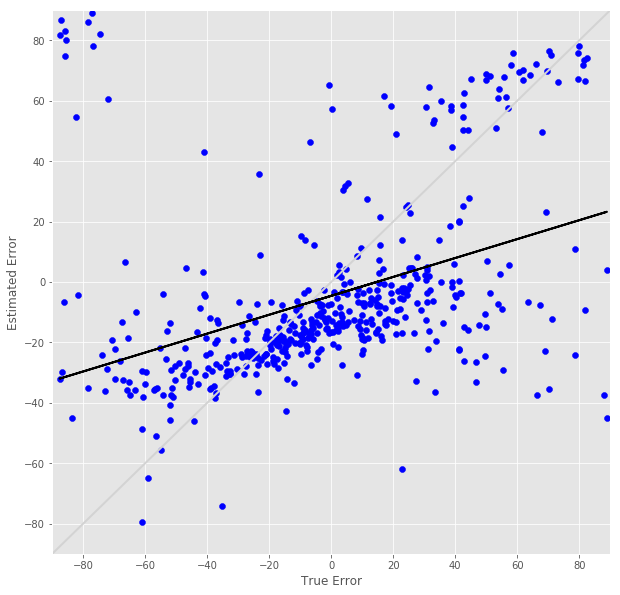

R^2 score for regression on RT: 0.1977
k = 0.8564


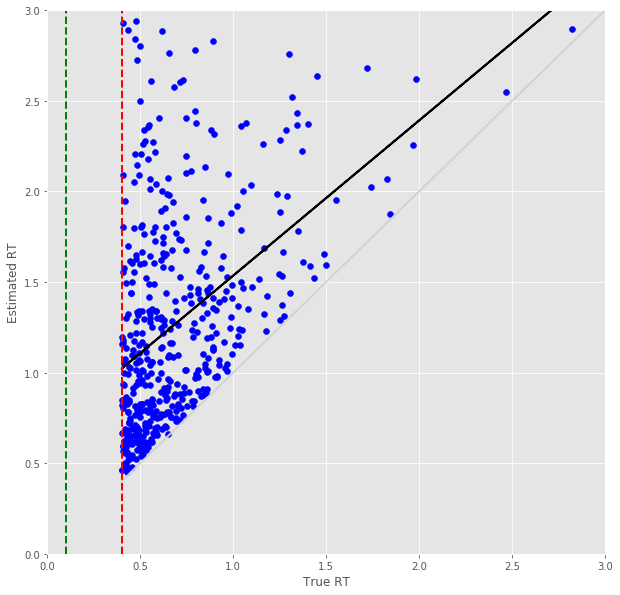

In [12]:
# plot Response Error and Reaction Time
plt.figure(figsize=(10, 10))
plt.style.use('ggplot')
plt.xlim(-90, 90)
plt.ylim(-90, 90)
plt.scatter(Observed_error, Estimated_error, color = 'b')
plt.xlabel("True Error")  
plt.ylabel("Estimated Error")
xx = numpy.linspace(-90, 90, 1000)
yy = xx
plt.plot(xx, yy, linewidth = 2, color = 'lightgrey')
Observed_error = numpy.array(Observed_error)
reg = LinearRegression().fit(Observed_error.reshape(-1, 1), Estimated_error)
print('R^2 score for regression on Error: %.4f' % (reg.score(Observed_error.reshape(-1, 1), Estimated_error)))
print('k = %.4f' % (reg.coef_))
pred = reg.predict(Observed_error.reshape(-1, 1))
plt.plot(Observed_error, pred, linewidth = 2, color = 'k')
plt.show()

plt.figure(figsize=(10, 10))
plt.style.use('ggplot')
plt.xlim(0, tmax)
plt.ylim(0, tmax)
plt.scatter(RT0, RT, color = 'b')
plt.xlabel("True RT")  
plt.ylabel("Estimated RT")
xx = numpy.linspace(EFFECTIVE_LOC * h, tmax, 1000)
yy = xx
plt.plot(xx, yy, linewidth = 2, color = 'lightgrey')
RT0 = numpy.array(RT0)
reg = LinearRegression().fit(RT0.reshape(-1, 1), RT)
print('R^2 score for regression on RT: %.4f' % (reg.score(RT0.reshape(-1, 1), RT)))
print('k = %.4f' % (reg.coef_))
pred = reg.predict(RT0.reshape(-1, 1))
plt.plot(RT0, pred, linewidth = 2, color = 'k')
plt.axvline((TRAIN_SIZE - 1) * h, linestyle="dashed", linewidth = 2, color='g')
plt.axvline(EFFECTIVE_LOC * h, linestyle="dashed", linewidth = 2, color='r')
plt.show()


In [13]:
# Output the prediction score
Observed_theta, Observed_error, Observed_locRT = [], [], []
Predicted_theta, Predicted_error, Predicted_locRT = [], [], []
for s in range(numSeries, numSeries + numPredict):
    a_r = a[s] - math.sqrt(h) * sigma[s] / 2.0
    for k in range(lentmax):
        temp = predictPredictPlot[s - numSeries, k, :]
        if (temp[0] ** 2 + temp[1] ** 2 >= a_r ** 2):
            Observed_locRT.append(RTloc[s])
            Predicted_locRT.append(k)
            Observed_theta.append(Response[s])
            tt = atan_positive(temp[0], temp[1]) / 2.0 / math.pi * 180
            Predicted_theta.append(tt)
            Observed_error.append(Error[s])
            Predicted_error.append(semicircular_error(tt, Target[s]))
            break
print len(Observed_error)

Res0_p = [i * math.pi / 180 for i in Observed_error]
Res_p = [i * math.pi / 180 for i in Predicted_error]
Err = Res
for i in range((len(Observed_error))):
    Err[i] = (semicircular_error(Predicted_error[i], Observed_error[i]) * math.pi / 180) ** 2
ResponsePredictionScore = math.sqrt(sum(Err) / len(Err))
RT0_p = [i * h for i in Observed_locRT]
RT_p = [i * h for i in Predicted_locRT]
RTPredictionScore = math.sqrt(mean_squared_error(RT0_p, RT_p))
            
print('Error Prediction Score: %.4f RMSE' % (ResponsePredictionScore))
print('RT Prediction Score: %.4f RMSE' % (RTPredictionScore))


84
Error Prediction Score: 0.4810 RMSE
RT Prediction Score: 0.7814 RMSE


R^2 score for regression on Error: 0.4236
k = 0.5646


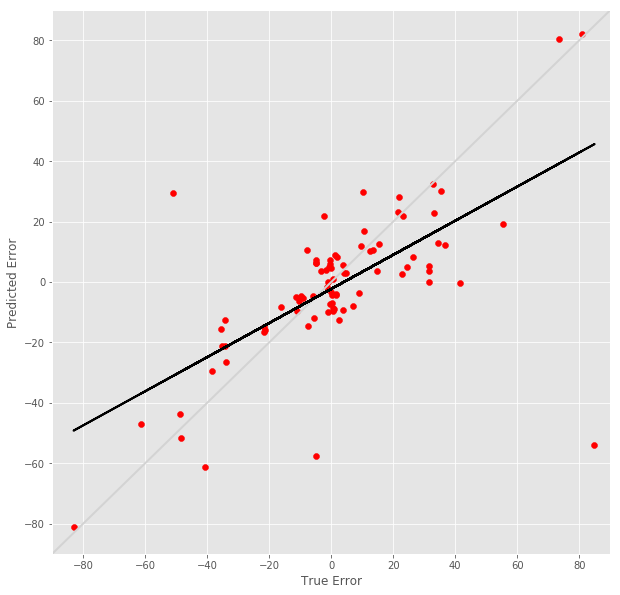

R^2 score for regression on RT: 0.4691
k = 1.2095


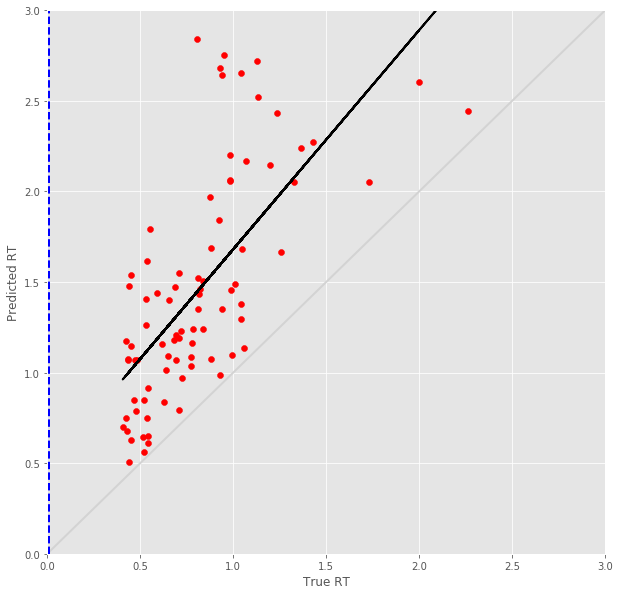

In [14]:
# plot Predicted Response Error and Reaction Time
plt.figure(figsize=(10, 10))
plt.style.use('ggplot')
plt.xlim(-90, 90)
plt.ylim(-90, 90)
plt.scatter(Observed_error, Predicted_error, color = 'r')
plt.xlabel("True Error")  
plt.ylabel("Predicted Error")
xx = numpy.linspace(-90, 90, 1000)
yy = xx
plt.plot(xx, yy, linewidth = 2, color = 'lightgrey')
Observed_error = numpy.array(Observed_error)
reg = LinearRegression().fit(Observed_error.reshape(-1, 1), Predicted_error)
print('R^2 score for regression on Error: %.4f' % (reg.score(Observed_error.reshape(-1, 1), Predicted_error)))
print('k = %.4f' % (reg.coef_))
pred = reg.predict(Observed_error.reshape(-1, 1))
plt.plot(Observed_error, pred, linewidth = 2, color = 'k')
plt.show()

plt.figure(figsize=(10, 10))
plt.style.use('ggplot')
plt.xlim(0, tmax)
plt.ylim(0, tmax)
plt.scatter(RT0_p, RT_p, color = 'r')
plt.xlabel("True RT")  
plt.ylabel("Predicted RT")
xx = numpy.linspace(0, tmax, 1000)
yy = xx
plt.plot(xx, yy, linewidth = 2, color = 'lightgrey')
RT0_p = numpy.array(RT0_p)
reg = LinearRegression().fit(RT0_p.reshape(-1, 1), RT_p)
print('R^2 score for regression on RT: %.4f' % (reg.score(RT0_p.reshape(-1, 1), RT_p)))
print('k = %.4f' % (reg.coef_))
pred = reg.predict(RT0_p.reshape(-1, 1))
plt.plot(RT0_p, pred, linewidth = 2, color = 'k')
plt.axvline((look_back - 1) * h, linestyle="dashed", linewidth = 2, color='b')
plt.show()
